In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/kaggle/input/spam-dataset/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]  # Select only the relevant columns
df.columns = ['label', 'message']  # Rename columns

# Display dataset info
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Label Distribution:\n{df['label'].value_counts()}")
print(f"Percentage of spam: {round(df['label'].value_counts()[1]/len(df)*100, 2)}%")

Dataset Overview:
Shape: (5572, 2)
Label Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
Percentage of spam: 13.41%


In [3]:
# Download NLTK resources (uncomment if not already downloaded)
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, remove_stopwords=True):
    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    tokens = word_tokenize(text)
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Preprocess messages for each class
ham_messages = df[df['label'] == 'ham']['message'].apply(preprocess_text)
spam_messages = df[df['label'] == 'spam']['message'].apply(preprocess_text)

# Function to get n-grams
def get_ngrams(tokens_list, n):
    ngrams_list = []
    for tokens in tokens_list:
        ngrams_list.extend(ngrams(tokens, n))
    return ngrams_list

# Calculate most frequent n-grams
def top_ngrams(ngrams_list, n=10):
    return Counter(ngrams_list).most_common(n)

# For ham messages
ham_words = [word for tokens in ham_messages for word in tokens]
ham_bigrams = get_ngrams(ham_messages, 2)
ham_trigrams = get_ngrams(ham_messages, 3)

# For spam messages
spam_words = [word for tokens in spam_messages for word in tokens]
spam_bigrams = get_ngrams(spam_messages, 2)
spam_trigrams = get_ngrams(spam_messages, 3)

print("Top 10 Ham Words:", top_ngrams(ham_words))
print("Top 10 Spam Words:", top_ngrams(spam_words))
print("\nTop 10 Ham Bigrams:", top_ngrams(ham_bigrams))
print("Top 10 Spam Bigrams:", top_ngrams(spam_bigrams))
print("\nTop 10 Ham Trigrams:", top_ngrams(ham_trigrams))
print("Top 10 Spam Trigrams:", top_ngrams(spam_trigrams))

Top 10 Ham Words: [('u', 988), ('im', 461), ('get', 307), ('ltgt', 276), ('ok', 272), ('dont', 268), ('go', 249), ('got', 244), ('ur', 240), ('ill', 240)]
Top 10 Spam Words: [('call', 350), ('free', 219), ('u', 155), ('txt', 151), ('ur', 144), ('mobile', 124), ('text', 121), ('stop', 116), ('claim', 113), ('reply', 101)]

Top 10 Ham Bigrams: [(('gon', 'na'), 58), (('call', 'later'), 50), (('ill', 'call'), 48), (('let', 'know'), 39), (('sorry', 'ill'), 39), (('r', 'u'), 37), (('u', 'r'), 37), (('dont', 'know'), 33), (('good', 'morning'), 30), (('wan', 'na'), 28)]
Top 10 Spam Bigrams: [(('please', 'call'), 46), (('po', 'box'), 28), (('p', 'per'), 25), (('contact', 'u'), 24), (('guaranteed', 'call'), 23), (('call', 'landline'), 23), (('prize', 'guaranteed'), 22), (('selected', 'receive'), 19), (('send', 'stop'), 19), (('every', 'week'), 19)]

Top 10 Ham Trigrams: [(('ill', 'call', 'later'), 42), (('sorry', 'ill', 'call'), 38), (('im', 'gon', 'na'), 20), (('happy', 'new', 'year'), 18), (('

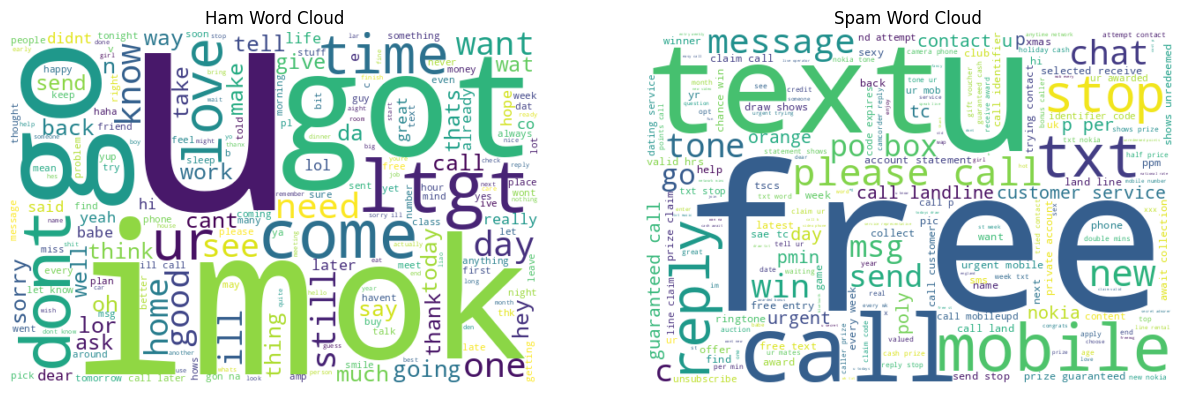

In [4]:
# Generate word clouds
ham_text = ' '.join(ham_words)
spam_text = ' '.join(spam_words)

ham_wordcloud = WordCloud(width=600, height=400, background_color='white').generate(ham_text)
spam_wordcloud = WordCloud(width=600, height=400, background_color='white').generate(spam_text)

# Plot word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(ham_wordcloud, interpolation='bilinear')
ax1.set_title('Ham Word Cloud')
ax1.axis('off')

ax2.imshow(spam_wordcloud, interpolation='bilinear')
ax2.set_title('Spam Word Cloud')
ax2.axis('off')
plt.show()

In [5]:
# Split the data
X = df['message']
y = df['label'].map({'ham': 0, 'spam': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bag-of-Words vectorization
bow_vectorizer = CountVectorizer(stop_words='english')
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [6]:
# Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_bow, y_train)
y_pred_bow = model.predict(X_test_bow)

# Calculate F1-score
f1_bow = f1_score(y_test, y_pred_bow)
print(f"F1-score with BoW: {f1_bow:.4f}")

F1-score with BoW: 0.9388


In [7]:
# Tf-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train the same model
model.fit(X_train_tfidf, y_train)
y_pred_tfidf = model.predict(X_test_tfidf)

# Calculate F1-score
f1_tfidf = f1_score(y_test, y_pred_tfidf)
print(f"F1-score with Tf-IDF: {f1_tfidf:.4f}")

F1-score with Tf-IDF: 0.8593


In [8]:
def enhanced_preprocessing(text):
    # Remove email IDs
    text = re.sub(r'\S+@\S+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

# Apply enhanced preprocessing
df['cleaned_message'] = df['message'].apply(enhanced_preprocessing)

# Split the preprocessed data
X_clean = df['cleaned_message']
X_train_clean, X_test_clean, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

# Tf-IDF vectorization on preprocessed text
tfidf_vectorizer_clean = TfidfVectorizer()
X_train_tfidf_clean = tfidf_vectorizer_clean.fit_transform(X_train_clean)
X_test_tfidf_clean = tfidf_vectorizer_clean.transform(X_test_clean)

# Train the model
model.fit(X_train_tfidf_clean, y_train)
y_pred_tfidf_clean = model.predict(X_test_tfidf_clean)

# Calculate F1-score
f1_tfidf_clean = f1_score(y_test, y_pred_tfidf_clean)
print(f"F1-score with Tf-IDF and preprocessing: {f1_tfidf_clean:.4f}")

F1-score with Tf-IDF and preprocessing: 0.8593


In [9]:
# Compare results
results = pd.DataFrame({
    'Method': ['Bag-of-Words', 'Tf-IDF', 'Tf-IDF with Preprocessing'],
    'F1-Score': [f1_bow, f1_tfidf, f1_tfidf_clean]
})
print(results)

                      Method  F1-Score
0               Bag-of-Words  0.938776
1                     Tf-IDF  0.859316
2  Tf-IDF with Preprocessing  0.859316
